# Data Cleaning

In [401]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pymc3 as pm

In [402]:
df = pd.read_csv('DB_edited.csv', encoding = "ISO-8859-1", engine='python')
df.head()


,the_source,country,region,sitename,Lat,Lon,Method,Year,depth_m,common name,Phylum,Class,Order,Family,Genus,genus species,Count,transect,den_per_100m2,den
0,LTO,Mozambique,Komame,Pao,-24.067983,35.053267,transect quadrats,2016.0,17.7,Granular starfish,Echinodermata,Asteroidea,Valvatida,Oreasteridae,Choriaster,Austrofromia schultzei,1,1,0.25,0.25
1,LTO,Mozambique,Komame,Pao,-24.067983,35.053267,transect quadrats,2016.0,16,Longspined Sea Urchin,Echinodermata,Echinoidea,Diadematoida,Diadematidae,Diadema,Diadema setosum,38,1,9.50,9.50
2,LTO,Mozambique,Komame,Neptune,-24.066992,35.503783,transect quadrats,2016.0,16,Magnificent Anemone,Cnidaria,Anthozoa,Actiniaria,Stichodactylidae,Heteractis,Heteractic mangnifica,2,1,0.50,0.50
3,LTO,Mozambique,Komame,Neptune,-24.066992,35.503783,transect quadrats,2016.0,16,Blue Starfish,Echinodermata,Asteroidea,Valvatida,Ophidiasteridae,Linckia,Linckia laevigata,1,1,0.25,0.25
4,LTO,Mozambique,Komame,Neptune,-24.066992,35.503783,transect quadrats,2016.0,17.7,Giant Anemone,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Condylactis,Heteractis magnifica,7,1,1.75,1.75


First attaching relevent variables

In [403]:
#three letter codes for each country
ctry_codes = pd.read_excel('Variables_condensed.xlsx', sheet_name='Country_codes')
#voice and accountability for each country
Voice = pd.read_excel('Variables_condensed.xlsx', sheet_name='Voice_&_Accountability')
#World Population by country
Population = pd.read_excel('Variables_condensed.xlsx', sheet_name='World_populations')
#Human Development Index
HDI = pd.read_excel('Variables_condensed.xlsx', sheet_name='HDI')
Population.head()

,Country Name,Country Code,Year,World_pop
0,Aruba,ABW,A,96735.0
1,Afghanistan,AFG,A,23653918.0
2,Angola,AGO,A,18155679.2
3,Albania,ALB,A,3037845.0
4,Andorra,AND,A,73136.6


2018.0    17255
2012.0    16640
2015.0    16241
2013.0    15946
2009.0    14529
2017.0    14428
2016.0    14047
2011.0    13813
2010.0    13411
2019.0    12265
2014.0    11352
2008.0     9309
2006.0     7577
2004.0     6868
2003.0     4702
2005.0     4139
2002.0     2380
2007.0     1936
2001.0     1025
2000.0      722
1997.0      720
1999.0      635
1998.0      190
0.0           6
Name: Year, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


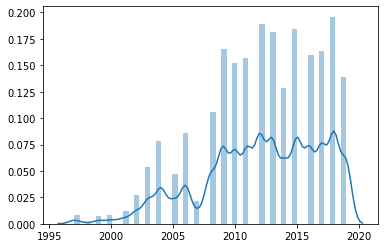

In [404]:
#figure out how split up year based off distribution

#remove NA's in Year
df = df.dropna(axis=0, subset=['Year'],inplace=False)
print(df['Year'].value_counts())

# remove year zeros
indexNames = df[df['Year'] == 0].index
df.drop(indexNames, inplace=True)

#plot distribution of year
histo = df['Year']
print(sns.distplot([histo]))

looks like 5 year incriments will be good from 2020 to maybe 2000, for now testing will remove if older than 2000

In [405]:
# remove data prior to 2001
indexNames = df[df['Year'] <= 2000].index
df.drop(indexNames, inplace=True)

# make 2001-2005 'A', 2006-2010 'B', 2011-2015 'C', 2016-2020 'D'
yeardict = {2001: 'A', 2002: 'A', 2003: 'A', 2004: 'A', 2005: 'A', 2006: 'B', 2007: 'B', 2008: 'B', 2009: 'B',
           2010: 'B', 2011: 'C', 2012: 'C', 2013: 'C', 2014: 'C', 2015: 'C', 2016: 'D', 2017: 'D', 2018: 'D',
           2019: 'D', 2020: 'D'} #create key and value for each
df = df.replace(yeardict)

Variables were averaged for each of the time frames A, B, C, D

In [406]:
# attach coulumn country codes
df = pd.merge(df, ctry_codes,  how='left', left_on=['country'], right_on=['Country']).drop(['Country'], axis=1)
#df.info()
#2,000 entries do not have a valid country name

In [407]:
#attach column HDI, Voice and Population
df = pd.merge(df, HDI,  how='left', left_on=['Code', 'Year'],
              right_on=['Country code', 'Year'], suffixes='_x')
df = pd.merge(df, Voice,  how='left', left_on=['Code', 'Year'],
              right_on=['Country Code', 'Year'], suffixes='_x')
df = pd.merge(df, Population,  how='left', left_on=['Code', 'Year'],
              right_on=['Country Code', 'Year'], suffixes='_x')
df = df.drop(['Country Name_', 'Country code', 'Country Code_', 'Country Namex',
            'Country Codex'], axis=1)
df['den'] = pd.to_numeric(df['den'], errors='coerce') #change density to float

In [408]:
#create our model df
df_base = df
df = df_base[['the_source', 'Code', 'Lat', 'Lon', 'Year', 'depth_m', 'Phylum', 'den', 'HDI', 'Voice', 'World_pop']].copy()
df.head()

,the_source,Code,Lat,Lon,Year,depth_m,Phylum,den,HDI,Voice,World_pop
0,LTO,MOZ,-24.067983,35.053267,D,17.7,Echinodermata,0.25,0.441,-0.435327,2.865830e+07
1,LTO,MOZ,-24.067983,35.053267,D,16,Echinodermata,9.50,0.441,-0.435327,2.865830e+07
2,LTO,MOZ,-24.066992,35.503783,D,16,Cnidaria,0.50,0.441,-0.435327,2.865830e+07
3,LTO,MOZ,-24.066992,35.503783,D,16,Echinodermata,0.25,0.441,-0.435327,2.865830e+07
4,LTO,MOZ,-24.066992,35.503783,D,17.7,Cnidaria,1.75,0.441,-0.435327,2.865830e+07


In [409]:
# create a unique ID for each site

df['Lat'] = df.Lat.astype(str) #convert to string to make unique ID
df['Lon'] = df.Lon.astype(str)
df = df.assign(id=(df['Lat'] + '_' + df['Lon']).astype('category').cat.codes)
df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce') #convert back to numeric
df['Lon'] = pd.to_numeric(df['Lon'], errors='coerce')
#df.head()
#make depth a float
df['depth_m'] = pd.to_numeric(df['depth_m'], errors='coerce')
df.id.max()

9313

Next get an average density and depth for each site based on unique_id (Lat, Lon), Phylum and year bracket

In [410]:
#this is median as to account for outliers

df.dropna(subset=['Code'], inplace=True) #drop nulls in Code
#df.isnull().sum() #the total null values for each column
#dfagg = df.groupby(['id', 'Year', 'Phylum']).agg({'depth_m': ['mean'],
        #                                 'den': ['mean']})
#dfagg
grouper = df.groupby(['id', 'Code', 'Year', 'Phylum'])
#grouper
#dfagg = dfagg.to_frame(name='depth_m_mean').rest_index()
df_ave = grouper.median()
df_ave = df_ave.add_suffix('_ave').reset_index()

df_ave.dropna(axis=0, subset=['Lat_ave'],inplace=True)
df_ave.dropna(axis=0, subset=['Lon_ave'],inplace=True)
#df_ave['id'].ffill(axis = 0)


#df_array = df_ave.values
#df_array[df_array[0]==''] = np.NaN
#df_array.fillna(method='ffill')

In [411]:
df_ave

,id,Code,Year,Phylum,Lat_ave,Lon_ave,depth_m_ave,den_ave,HDI_ave,Voice_ave,World_pop_ave
0,0,IDN,D,Arthropoda,-0.011100,27.181790,8.0,0.40,0.703667,0.158766,2.646212e+08
1,0,IDN,D,Chordata,-0.011100,27.181790,8.0,3.20,0.703667,0.158766,2.646212e+08
2,0,IDN,D,Echinodermata,-0.011100,27.181790,8.0,0.80,0.703667,0.158766,2.646212e+08
3,0,IDN,D,Mollusca,-0.011100,27.181790,8.0,0.40,0.703667,0.158766,2.646212e+08
4,1,IDN,B,Arthropoda,-0.035833,119.795000,9.0,0.75,0.652000,-0.030827,2.355234e+08
...,...,...,...,...,...,...,...,...,...,...,...
23266,9310,PHL,C,Arthropoda,9.999732,125.203954,6.0,9.50,0.690400,0.052619,9.885612e+07
23267,9310,PHL,C,Echinodermata,9.999732,125.203954,6.0,9.00,0.690400,0.052619,9.885612e+07
23268,9310,PHL,C,EchinodermataÂ,9.999732,125.203954,6.0,2.00,0.690400,0.052619,9.885612e+07
23269,9310,PHL,C,Mollusca,9.999732,125.203954,6.0,3.00,0.690400,0.052619,9.885612e+07


Split up by species so Echinodermata will be examined first

In [412]:
Echin = df_ave[df_ave['Phylum']=='Echinodermata']
Echin.to_csv(r'C:\Users\stuar\Documents\GitHub\Bright_spot\Inverts_DB\Echinoderm_ave.csv', index = False)

In [413]:
Echin
# Isolate inverts density
density = Echin.den_ave.values
# Create log(den) response variable
density = density+min(density[density!=0])
# Create log(biomass) response variable
ldensity = np.log(density + 0.1)
#ldensity = np.log(density+min(density[density!=0]))
# Total number of observations
nobs = len(ldensity)
nobs

8908

In [414]:
#this area of making a logged and unlogged density is a bit off

#Echin.shape
Echin['lden'] = ldensity
Echin['den'] = Echin['den_ave']
Echin.head()
#plt.hist(df.den)

C:\Users\stuar\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\stuar\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,Code,Year,Phylum,Lat_ave,Lon_ave,depth_m_ave,den_ave,HDI_ave,Voice_ave,World_pop_ave,lden,den
2,0,IDN,D,Echinodermata,-0.011100,27.18179,8.0,0.8,0.703667,0.158766,2.646212e+08,0.139762,0.8
5,1,IDN,B,Echinodermata,-0.035833,119.79500,3.0,0.5,0.652000,-0.030827,2.355234e+08,-0.162519,0.5
7,2,IDN,B,Echinodermata,-0.036667,119.74300,3.0,1.5,0.652000,-0.030827,2.355234e+08,0.615186,1.5
9,3,ECU,B,Echinodermata,-0.040000,-91.52000,6.0,2.2,0.708000,-0.223746,1.453544e+07,0.936093,2.2
10,4,ECU,B,Echinodermata,-0.040000,-91.53000,6.0,1.8,0.708000,-0.223746,1.453544e+07,0.765468,1.8


In [415]:
#clean
Echin.rename(columns={'Lat_ave':'Lat',
                          'Lon_ave':'Lon',
                          'depth_m_ave':'depth',
                     'HDI_ave':'HDI',
                     'Voice_ave':'Voice',
                     'World_pop_ave':'Population'}, 
                 inplace=True)

C:\Users\stuar\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(array([ 778., 3435., 1808., 1044.,  674.,  479.,  334.,  235.,  100.,
          20.]),
 array([-1.04982212, -0.29518504,  0.45945204,  1.21408913,  1.96872621,
         2.7233633 ,  3.47800038,  4.23263747,  4.98727455,  5.74191164,
         6.49654872]),
 <a list of 10 Patch objects>)

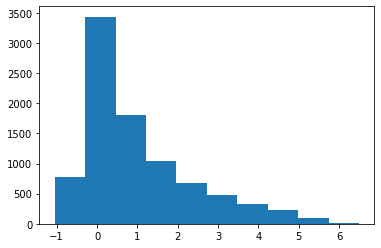

In [416]:
plt.hist(Echin.lden)

In [417]:
#depth
tmp = np.array(Echin.depth.values) #convert to an array
tmp = tmp.astype(int)
tmp = np.where(tmp <= 6, 0, tmp)
tmp = np.where(tmp > 6, 1, tmp)
Echin['depth'] = tmp
Echin.depth.value_counts()

C:\Users\stuar\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    5152
1    3756
Name: depth, dtype: int64

In [418]:
#remove latitutes above and under 30 
Echin = Echin[(Echin.Lat <= 30) & (Echin.Lat >= -30)]

In [419]:
Echin['Country_number'] = pd.factorize(Echin.Code)[0]
Echin

,id,Code,Year,Phylum,Lat,Lon,depth,den_ave,HDI,Voice,Population,lden,den,Country_number
2,0,IDN,D,Echinodermata,-0.011100,27.181790,1,0.80,0.703667,0.158766,2.646212e+08,0.139762,0.80,0
5,1,IDN,B,Echinodermata,-0.035833,119.795000,0,0.50,0.652000,-0.030827,2.355234e+08,-0.162519,0.50,0
7,2,IDN,B,Echinodermata,-0.036667,119.743000,0,1.50,0.652000,-0.030827,2.355234e+08,0.615186,1.50,0
9,3,ECU,B,Echinodermata,-0.040000,-91.520000,0,2.20,0.708000,-0.223746,1.453544e+07,0.936093,2.20,1
10,4,ECU,B,Echinodermata,-0.040000,-91.530000,0,1.80,0.708000,-0.223746,1.453544e+07,0.765468,1.80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23255,9306,PHL,B,Echinodermata,9.996940,123.370000,1,0.50,0.665000,-0.081467,9.091541e+07,-0.162519,0.50,30
23256,9307,PHL,B,Echinodermata,9.997170,123.354000,1,0.25,0.665000,-0.081467,9.091541e+07,-0.510826,0.25,30
23257,9308,PHL,B,Echinodermata,9.999170,123.373000,0,0.50,0.665000,-0.081467,9.091541e+07,-0.162519,0.50,30
23261,9309,PHL,C,Echinodermata,9.999643,125.203652,1,4.00,0.690400,0.052619,9.885612e+07,1.470176,4.00,30


In [420]:
Echin.to_csv(r'C:\Users\stuar\Documents\GitHub\Bright_spot\Inverts_DB\Echinoderm_ave.csv', index = False)

In [421]:
#cluster points to within 4.5 km of each other
Cluster = pd.read_csv(r'C:\Users\stuar\Documents\GitHub\Bright_spot\Inverts_DB\Echinoderm_cluster.csv', encoding = "ISO-8859-1", engine='python')
Cluster = Cluster.drop(['ID', 'optional'], axis=1)
Cluster

,clust,coords.x1,coords.x2
0,1,27.181790,-0.011100
1,2,119.795000,-0.035833
2,3,119.743000,-0.036667
3,4,-91.520000,-0.040000
4,4,-91.530000,-0.040000
...,...,...,...
7107,2169,123.370000,9.996940
7108,2169,123.354000,9.997170
7109,2169,123.373000,9.999170
7110,996,125.203652,9.999643


In [422]:
#cluster as dictionary - nope dictionaries can only have one key
cluster_test = pd.merge(Cluster, Echin, how='inner', left_on=['coords.x2', 'coords.x1'],
                            right_on=['Lat', 'Lon'])

#cluster_test = Cluster.join(Cluster, Echin, on=['coords.x2','coords.x1'],
                    #       how='inner')
#pd.merge(Echin, Cluster,  how='left', left_on=['Lat', 'Lon'],
            #  right_on=['coords.x2', 'coords.x1'], suffixes='_x')
cluster_test = cluster_test[(cluster_test['coords.x1'] == cluster_test['Lon']) & (cluster_test['coords.x2'] == cluster_test['Lat'])]
#cluster_test = cluster_test.drop_duplicates(subset=['coords.x1','coords.x2'])

#make sure no duplicate lat and lon
cluster_test = cluster_test.sort_values('clust').drop_duplicates(subset=['Lat', 'Lon'], keep='last')
cluster_test = cluster_test.drop(['coords.x1', 'coords.x2'], axis=1)
cluster_test


,clust,id,Code,Year,Phylum,Lat,Lon,depth,den_ave,HDI,Voice,Population,lden,den,Country_number
0,1,0,IDN,D,Echinodermata,-0.011100,27.181790,1,0.8,0.703667,0.158766,2.646212e+08,0.139762,0.8,0
1,2,1,IDN,B,Echinodermata,-0.035833,119.795000,0,0.5,0.652000,-0.030827,2.355234e+08,-0.162519,0.5,0
2,3,2,IDN,B,Echinodermata,-0.036667,119.743000,0,1.5,0.652000,-0.030827,2.355234e+08,0.615186,1.5,0
3,4,3,ECU,B,Echinodermata,-0.040000,-91.520000,0,2.2,0.708000,-0.223746,1.453544e+07,0.936093,2.2,1
4,4,4,ECU,B,Echinodermata,-0.040000,-91.530000,0,1.8,0.708000,-0.223746,1.453544e+07,0.765468,1.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10371,2170,9295,PHL,D,Echinodermata,9.971735,125.219784,1,1.0,0.708333,0.094165,1.051630e+08,0.300105,1.0,30
10376,2170,9300,PHL,D,Echinodermata,9.974668,125.217616,0,4.0,0.708333,0.094165,1.051630e+08,1.470176,4.0,30
10375,2170,9299,PHL,D,Echinodermata,9.973939,125.218505,0,1.5,0.708333,0.094165,1.051630e+08,0.615186,1.5,30
10374,2170,9298,PHL,D,Echinodermata,9.973677,125.218503,1,1.0,0.708333,0.094165,1.051630e+08,0.300105,1.0,30


In [475]:
#hold off on Grouper

grouper = cluster_test.groupby(['clust'])
df_ave = grouper.median() #tested and def works
Echin1 = df_ave.add_suffix('_clust').reset_index()





Echin1 = Echin1.drop(['depth_clust', 'Country_number_clust', 'den_ave_clust'], axis = 1)


cluster_test1 = cluster_test.drop_duplicates(subset=['clust'], keep = 'first')
Echin1 = pd.merge(Echin1, cluster_test1, how='left', left_on=['clust'],
          right_on=['clust'], suffixes=('_l', '_r'))

Echin1 = Echin1.drop(['HDI_clust', 'id_clust', 'Lat_clust', 'Lon_clust', 'den_ave', 'Voice_clust', 'Population_clust', 'lden', 'den', 'id'], axis = 1)
Echin1 = Echin1.rename(columns={"lden_clust":"lden", "den_clust": "den"})
Echin1 #final dataframe for now!!
#replace depth and country number now
#can add in country code using cluster test
#come back and deal with Year averages later


,clust,lden,den,Code,Year,Phylum,Lat,Lon,depth,HDI,Voice,Population,Country_number
0,1,0.139762,0.800,IDN,D,Echinodermata,-0.011100,27.181790,1,0.703667,0.158766,2.646212e+08,0
1,2,-0.162519,0.500,IDN,B,Echinodermata,-0.035833,119.795000,0,0.652000,-0.030827,2.355234e+08,0
2,3,0.615186,1.500,IDN,B,Echinodermata,-0.036667,119.743000,0,0.652000,-0.030827,2.355234e+08,0
3,4,0.936093,2.200,ECU,B,Echinodermata,-0.040000,-91.520000,0,0.708000,-0.223746,1.453544e+07,1
4,5,0.667829,1.600,ECU,B,Echinodermata,-0.050000,-91.540000,0,0.708000,-0.223746,1.453544e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,2166,1.470176,4.000,PHL,C,Echinodermata,9.961280,125.067664,1,0.690400,0.052619,9.885612e+07,30
2166,2167,4.401829,81.250,VNM,A,Echinodermata,9.974780,104.017000,0,0.602200,-1.416045,8.229481e+07,32
2167,2168,2.107178,7.875,THA,B,Echinodermata,9.958060,99.970500,1,0.711400,-0.556614,6.651749e+07,33
2168,2169,-0.510826,0.250,PHL,A,Echinodermata,9.972670,123.369000,0,0.645000,0.084176,8.302538e+07,30


In [291]:
#Echin.to_csv(r'C:\Users\stuar\Documents\GitHub\Bright_spot\Inverts_DB\Echinoderm_clust.csv', index = False)

In [ ]:
#got from vlookup in excel on cluster from csv Echinoderm_clust & Echinoderm_clust_with_code
#read. 

In [476]:
countries = Echin1.Code.unique() #this is where I should use my country code
n_countries = countries.shape[0] #
country = Echin1.Country_number.values #this is same as county, just numbers, so maybe make a country # ID
log_den = Echin1.lden.values #response so log density
depth = Echin1.depth.values #for me will be depth
log_HDI = np.log(Echin1.HDI.values) #Country for me this will be HDI
country_lookup = dict(zip(countries, np.arange(n_countries))) #creating a dictionary

# Practice model, Copy of Radon

### Pooled model

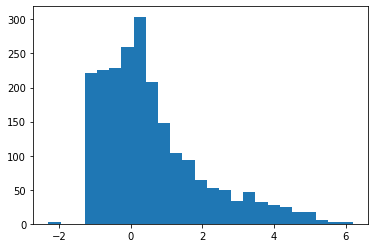

In [477]:
#Distribution of den levels (log scale):
Echin1.den.apply(lambda x: np.log(x+.1)).hist(bins=25, grid=False);

In [478]:
#for the complete pooling model: #so just practice wont u


#Here are the point estimates of the slope and intercept

from pymc3 import Model, sample, Normal, HalfCauchy, Uniform 
#might not be Uniform for me
#might not be normal

depth = Echin1.depth.values #depth 
lden = Echin1.lden.values #density

with Model() as pooled_model:
    
    β = Normal('β', 0, sigma=10, shape=2)
    σ = HalfCauchy('σ', 5)
    
    θ = β[0] + β[1]*depth
    
    y = Normal('y', θ, sigma=σ, observed=lden)

In [479]:
from pymc3 import sample_prior_predictive

with pooled_model:
    
    prior_checks = sample_prior_predictive(samples=1000)

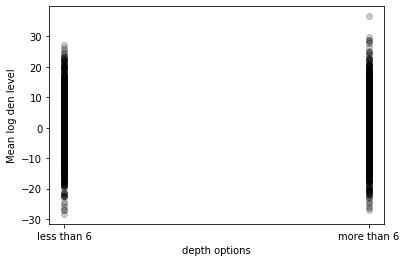

In [480]:
plt.plot(
    [0, 1], 
    [prior_checks["β"][:, 0], prior_checks["β"][:, 1]],
    "ok",
    alpha=0.2)
plt.xlabel("depth options")
plt.xticks([0,1], ["less than 6", "more than 6"])
plt.ylabel("Mean log den level");
#These look fine--they allow for any radon values that
#we would reasonably expect to see in the data.

In [481]:
with pooled_model:
    pooled_trace = sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:11<00:00, 353.64draws/s]


In [482]:
b0, m0 = pooled_trace['β'].mean(axis=0)

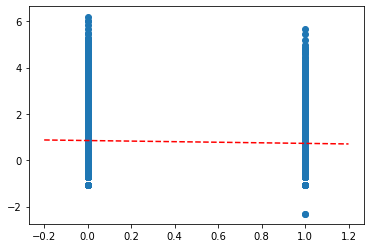

In [483]:
plt.scatter(Echin1.depth, np.log(Echin1.den+0.1)) #activity reflects unlogged radon
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');
#this looks like what I saw in the paper
#progress!!!

C:\Users\stuar\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\stuar\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


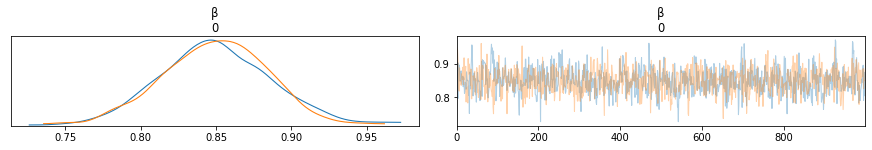

In [485]:
#pooled model sampleing
from arviz import plot_trace

plot_trace(pooled_trace, var_names=['β']);

## Unpooled model

In [486]:
#Estimates of country density levels for the unpooled model:

with Model() as unpooled_model:
    
    β0 = Normal('β0', 0, sigma=10, shape=n_countries)
    β1 = Normal('β1', 0, sigma=10)
    σ = HalfCauchy('σ', 5)
    
    θ = β0[country] + β1*depth
    
    y = Normal('y', θ, sigma=σ, observed=lden)

In [488]:
RANDOM_SEED = 20090425
with unpooled_model:
    unpooled_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β1, β0]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:10<00:00, 369.66draws/s]


In [489]:
unpooled_estimates = pd.Series(unpooled_trace['β0'].mean(axis=0), index=countries)
unpooled_se = pd.Series(unpooled_trace['β0'].std(axis=0), index=countries)

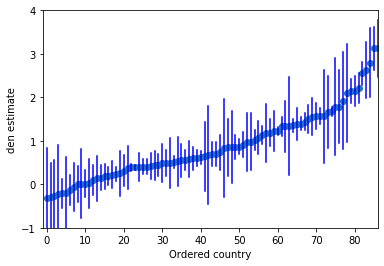

In [491]:
#We can plot the ordered estimates to identify countries with high density levels
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('den estimate');plt.xlabel('Ordered country');


Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

In [ ]:
from matplotlib.lines import Line2D

sample_countries = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['β1'].mean()
for i,c in enumerate(sample_counties):
    y = radon_data.log_radon[radon_data.county==c]
    x = radon_data.floor[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['under 6m', 'over 6m'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log den level')
        
custom_lines = [Line2D([0], [0]),
                Line2D([0], [0], ls='--',c='r')]

axes[0].legend(custom_lines, ['Unpooled', 'Pooled']);

# Scales Break from basic Model

In [12]:
# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

In [13]:
"""
# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out) 
"""

'\n# Return list of unique items and an index of their position in L\ndef indexall(L):\n    poo = []\n    for p in L:\n        if not p in poo:\n            poo.append(p)\n    Ix = np.array([poo.index(p) for p in L])\n    return poo,Ix\n\n# Return list of unique items and an index of their position in long, relative to short\ndef subindexall(short,long):\n    poo = []\n    out = []\n    for s,l in zip(short,long):\n        if not l in poo:\n            poo.append(l)\n            out.append(s)\n    return indexall(out) \n'

In [22]:
# Isolate inverts density
density = df.den.values
# Create log(den) response variable
density = density+min(density[density!=0])
# Create log(biomass) response variable
ldensity = np.log(density + 1)
#ldensity = np.log(density+min(density[density!=0]))
# Total number of observations
nobs = len(ldensity)
nobs

207738

In [23]:
df['den'] = ldensity

(array([1.28216e+05, 3.61020e+04, 1.79860e+04, 1.20610e+04, 7.03100e+03,
        2.70700e+03, 7.15000e+02, 2.89000e+02, 6.10000e+01, 2.00000e+00]),
 array([0.22314355, 1.1090941 , 1.99504465, 2.8809952 , 3.76694575,
        4.65289629, 5.53884684, 6.42479739, 7.31074794, 8.19669849,
        9.08264904]),
 <a list of 10 Patch objects>)

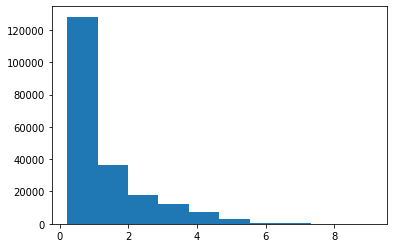

In [16]:
plt.hist(df.den)


#looks super skewed but much better than when not logged 

just going to work with environmental and large scale for now

Environmental scale - which is the scale at which the observations are made (usually a transect), and includes covariates relating to habitat type and protection from fishing (if any);

Social-site scale - defined by 4km radius clusters that include covariates relating to local human populations and general reef conditions such as storm activity, climate stress, and markets;

Larger scale - defined by more broad-scale social conditions that typically map onto countries, such as total fish landings and human development index ratings.

In [91]:
#Environmental scale

# Depth - turn into ordinal values

tmp = np.array(df.depth_m.values) #convert to an array
tmp = tmp.astype(int)
tmp = np.where(tmp <= 4, 0, tmp)
tmp = np.where(((tmp >= 5) & (tmp <=10)), 1, tmp)
tmp = np.where(tmp >=11, 2, tmp)
df['depth_m'] = tmp

#convert to ordinal shallow = 0, mid = 1, deep = 2

#protection Status --- ignored for now


#productivity -- - ignored for now 

#data provider -- this is where addressed in intial analysis
#Provider,Ip = indexall(df.the_source.values)
#nprovider = len(Provider)

# Need to develop 4km social sites / reefs

Next is social site scale 

In [92]:
#skipped for now
"""
#first cluster sites together to make a 'reef'


# Index observations to social-site scale
SSite,Iss = indexall(serfdata.SocialSIte4km.values)
# Number of social-sites
nsites = len(SSite)
nsites #how many sites
# Number of environmental observations per social-site
sstotals = np.array([sum(Iss==i) for i in np.unique(Iss)])


# Use Python list indexing to create social-site indexing array
rindx = np.array([[x for x in Iss].index(i) for i in xrange(nsites)])
"""

"\n#first cluster sites together to make a 'reef'\n\n\n# Index observations to social-site scale\nSSite,Iss = indexall(serfdata.SocialSIte4km.values)\n# Number of social-sites\nnsites = len(SSite)\nnsites #how many sites\n# Number of environmental observations per social-site\nsstotals = np.array([sum(Iss==i) for i in np.unique(Iss)])\n\n\n# Use Python list indexing to create social-site indexing array\nrindx = np.array([[x for x in Iss].index(i) for i in xrange(nsites)])\n"

In [93]:
#Skipped for now



#regional population density

#Local Population density

#Atoll

#Climate stress

#productivity

#Storms

#regional pop growth

#linear distance to market

#Gravity to cities

#Gravity NP

#Gravity total


The next step is to create some larger-scale indexing, so the social-site scale parameters can be matched to the proper larger scale group:

In [94]:
#so for me for now I can skip as I have 
#no social scale to apply to large scale


# Indexing to map social-site scale onto larger scale
"""
Larger,Il = subindexall(df.Larger.values,df.SocialSIte4km.values) 
nlarger = len(Larger) # how many nations?
print(nlarger)
"""
#trying to use ID for social site rn...
"""
Larger, IL = subindexall(df.Code.unique(), df.id.unique()) # i have now switched it to number of nations
nlarger = len(Larger) # how many nations?
print(nlarger) #it prints out as two... I wonder if that's right... maybe meant to be the variables...
"""

"\nLarger, IL = subindexall(df.Code.unique(), df.id.unique()) # i have now switched it to number of nations\nnlarger = len(Larger) # how many nations?\nprint(nlarger) #it prints out as two... I wonder if that's right... maybe meant to be the variables...\n"

In [95]:
df[df.id == 1] #just making sure df and values are all good

,the_source,Code,Lat,Lon,Year,depth_m,Phylum,den,HDI,Voice,World_pop,id
0,LTO,MOZ,-24.067983,35.053267,D,2,Echinodermata,0.405465,0.441,-0.435327,2.865830e+07,1
1,LTO,MOZ,-24.067983,35.053267,D,2,Echinodermata,2.374906,0.441,-0.435327,2.865830e+07,1
6,LTO,MOZ,-24.067983,35.053267,D,2,Echinodermata,0.405465,0.441,-0.435327,2.865830e+07,1
7,LTO,MOZ,-24.067983,35.053267,D,2,Echinodermata,0.405465,0.441,-0.435327,2.865830e+07,1
8,LTO,MOZ,-24.067983,35.053267,D,2,Echinodermata,1.832581,0.441,-0.435327,2.865830e+07,1
13,LTO,MOZ,-24.067983,35.053267,D,2,Cnidaria,0.405465,0.441,-0.435327,2.865830e+07,1
14,LTO,MOZ,-24.067983,35.053267,D,2,Cnidaria,0.916291,0.441,-0.435327,2.865830e+07,1
15,LTO,MOZ,-24.067983,35.053267,D,2,Echinodermata,2.505526,0.441,-0.435327,2.865830e+07,1
16,LTO,MOZ,-24.067983,35.053267,D,2,Cnidaria,0.693147,0.441,-0.435327,2.865830e+07,1
42,LTO,MOZ,-24.067983,35.053267,D,2,Echinodermata,0.405465,0.441,-0.435327,2.865830e+07,1


Then set up an indexing array to pluck out a single value for each larger scale covariate:

In [96]:
# Larger-scale indexing for data
"""
.values() takes the values of a dictionary... whcih means I need 
 countries and a bunch of values for each country, 
 but why is it in this df then??? and not its own
 
 So I will set up a dictionary and see how it works out - but after
 we seperate each covariate....so I'm guessing it's just countries
 
"""

#len(psdata.index.unique())
"""
tmpL,Ilx = indexall(df.Code.values)  #this might meant to be a list of the covariates or countries?
lsite = [x for x in Ilx]
lindx = np.array([lsite.index(i) for i in range(nlarger)])
lindx
#just x range doesn't work rn because python 2 
#need to understand this array below
"""

"\ntmpL,Ilx = indexall(df.Code.values)  #this might meant to be a list of the covariates or countries?\nlsite = [x for x in Ilx]\nlindx = np.array([lsite.index(i) for i in range(nlarger)])\nlindx\n#just x range doesn't work rn because python 2 \n#need to understand this array below\n"

In [97]:
#large scale
#So i might need an average biomass for each country?? is that how this works?
#but the pymc3 practice didn't do this... they just used merge


#world Population
#lg_pop = stdize(np.log(df.World_pop.values+1))
#df['World_pop'] = lg_pop

df['World_pop'] = np.log(df['World_pop']+1)
df['World_pop'] = stdize(df['World_pop'])


#gov_auto = np.array(serfdata.Governance_autonomy.values[lindx])
#gov_auto = 1*(gov_auto=="Independent")


#HDI
#HDI = stdize(np.array(df.HDI.values))
#df['HDI'] = HDI
df['HDI'] = np.log(df['HDI']+1)
df['HDI'] = stdize(df['HDI'])

#something def wrong with HDI

#need to make sure lindx is right!! 

#Voice
#Voice = stdize(np.array(df.Voice.values))
#df['Voice'] = Voice
df['Voice'] = np.log(df['Voice']+1)
df['Voice'] = stdize(df['Voice'])



#array method did not worked....

In [98]:
df1 = df
df1.isnull().sum()

the_source      0
Code            0
Lat             0
Lon             0
Year            0
depth_m         0
Phylum          4
den             0
HDI           100
Voice           0
World_pop       0
id              0
dtype: int64

We also need a lookup table (dict) for each unique county, for indexing.

In [99]:
df.Code = df.Code.map(str.strip) # make county a string
mn_Codes = df.Code.unique() #get unique country codes
Code_len = len(mn_Codes) #get the length of that
#i guess a way to look things up...
Code_lookup = dict(zip(mn_Codes, range(len(mn_Codes)))) 
n_countries = mn_Codes.shape[0]
country = df.Code.values

Finally, create local copies of variables.

In [100]:
country = df['Country_code'] = df.Code.replace(Code_lookup).values
density = df.den
depth = df.depth_m.values

# BHM

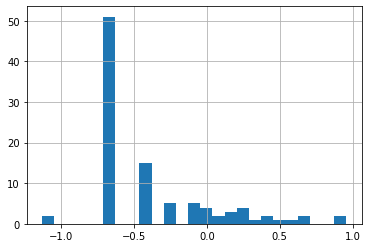

In [101]:
df.den.apply(lambda x: np.log(x+0.1)).hist(bins=25);
#this looks kind of awful ...
#maybe a solution could be to do the averages outlined above?
#also still some negatives... how??

In [72]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform

depth = df.depth_m.values #site level
log_den = df.den.values #made earlier?

with Model() as pooled_model:

    beta = Normal('beta', 0, sigma=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*depth

    y = Normal('y', theta, sigma=sigma, observed=log_den)

In [73]:
#single variate partial pooling (countries)
with Model() as partial_pooling:

    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = HalfCauchy('sigma_a', 5) #think this is sampling method

    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=Code_len)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[country]

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_den)


In [33]:
with partial_pooling:
    partial_pooling_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]
Sampling 4 chains, 292 divergences: 100%|██████████████████████████████████████| 8000/8000 [00:17<00:00, 449.86draws/s]
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44640462240111883, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, Countries = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=counties)

n_country = df.groupby('Country_code')['id'].count()
unpooled_means = srrs_mn.groupby('Country_code')['log_radon'].mean()
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')


samples, counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

In [35]:
#deterministic radon example

"""
from pymc3 import Deterministic
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform
with Model() as hierarchical_intercept:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., sigma=1e5)
    gamma_1 = Normal('gamma_1', mu=0., sigma=1e5)


    # Uranium model for intercept
    mu_a = gamma_0 + gamma_1*u
    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sigma=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=1e5)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
"""

"\nfrom pymc3 import Deterministic\nfrom pymc3 import Model, sample, Normal, HalfCauchy, Uniform\nwith Model() as hierarchical_intercept:\n\n    # Priors\n    sigma_a = HalfCauchy('sigma_a', 5)\n\n    # County uranium model for slope\n    gamma_0 = Normal('gamma_0', mu=0., sigma=1e5)\n    gamma_1 = Normal('gamma_1', mu=0., sigma=1e5)\n\n\n    # Uranium model for intercept\n    mu_a = gamma_0 + gamma_1*u\n    # County variation not explained by uranium\n    eps_a = Normal('eps_a', mu=0, sigma=sigma_a, shape=counties)\n    a = Deterministic('a', mu_a + eps_a[county])\n\n    # Common slope\n    b = Normal('b', mu=0., sigma=1e5)\n\n    # Model error\n    sigma_y = Uniform('sigma_y', lower=0, upper=100)\n\n    # Expected value\n    y_hat = a + b * floor_measure\n\n    # Data likelihood\n    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)\n"

Below is the Provided Code for Bright Spot model python 2 MC2

In [41]:
# Global log-biomass
with Model() as larger_model:
    gamma_0 = pm.Normal('den', mu=5.0, tau=0.01, shape=3)

    # Standard deviation of intercepts
    sigma1 = pm.Uniform('SD1', lower=0, upper=100000) 
    # Precisions of larger-scale intercepts
    tau1 = pm.Lambda('tau1', lambda sd=sigma1: sd**-2)

    # Larger-scale parameters of interest
    gamma_names = ('lg_pop','HDI', 'Voice')
    ngcov = len(gamma_names)

    # Larger covaraites
    gamma = pm.Normal('gamma', mu=0.0, tau=0.001, value=np.zeros(ngcov))
    # Labeled covaraites
    gammaL = [pm.Lambda('%s'%gamma_names[i], lambda g=gamma[i]: g) for i in range(ngcov)]

# Linear model for larger-scale intercepts
#eta_mu = pm.Lambda('eta_mu', lambda g0=gamma_0, g1=gamma[0], g2=gamma[1], g3=gamma[2], g4=gamma[3], g5=gamma[4]: 
               #    g0+g1*lg_pop+g2*hdi+g3*voice+g4*landings+g5*tourism)

# Distribution of larger-scale intercepts
#eta_0 = pm.Normal('larger_biomass', mu=eta_mu, tau=tau1, value=Lobs)

AttributeError: module 'pymc3' has no attribute 'Lambda'

Radon example switch out

In [103]:
#move up later

depth_m = df.depth_m.values
log_den = df.den.values

In [104]:
with Model() as varying_intercept_slope:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=10)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    mu_b = Normal('mu_b', mu=0., sigma=10)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=n_countries)
    # Random slopes
    b = Normal('b', mu=mu_b, sigma=sigma_b, shape=n_countries)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a[country] + b[country] * depth_m
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_den)

In [107]:
with varying_intercept_slope:
    varying_intercept_slope_trace = sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 2 chains, 618 divergences: 100%|██████████████████████████████████████| 4000/4000 [00:23<00:00, 172.99draws/s]
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 582 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30045757356817504, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


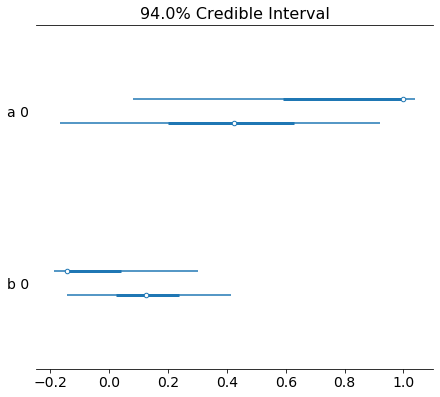

In [109]:
from arviz import plot_forest
plot_forest(varying_intercept_slope_trace, var_names=['a','b']);

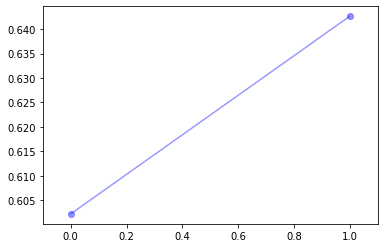

In [110]:
xvals = np.arange(2)
bp2 = varying_intercept_slope_trace['a'].mean(axis=0)
mp2 = varying_intercept_slope_trace['b'].mean(axis=0)
for bi,mi in zip(bp2,mp2):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);